In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import boto3

2023-12-02 19:45:17.938900: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 19:45:18.554291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 19:45:18.554344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 19:45:18.683824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 19:45:18.974392: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 19:45:18.976979: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
#This code sets up an LSTM-based model for satire classification.

In [4]:
# Set the S3 bucket and folder path
s3_bucket = 'satire-spotter-data'
s3_folder = 'satire'
s3_checkpoint_folder = 'checkpointed-full-datasets'

# Initialize S3 client
s3_client = boto3.client('s3')

In [5]:
# List objects in the S3 folder
s3_objects = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=f'{s3_checkpoint_folder}/')

# Sort objects by last modified time
sorted_objects = sorted(s3_objects['Contents'], key=lambda x: x['LastModified'], reverse=True)

# Get the most recently modified object (the latest dataset)
latest_object = sorted_objects[0]

# Get the S3 object key for the latest dataset
s3_object_key = latest_object['Key']

# Read the latest dataset directly into a DataFrame
training_df_extended = pd.read_csv(f's3://{s3_bucket}/{s3_object_key}')

/usr/local/lib/python3.9/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [6]:
X = training_df_extended['content']
y = training_df_extended['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Tokenize and pad sequences
max_words = 20000
maxlen = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)

In [8]:
#build model
embedding_dim = 128

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 300, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2622913 (10.01 MB)
Trainable params: 26229

In [9]:
batch_size = 128
epochs = 5

# Convert 'true' to 0 and 'satire' to 1
y_train_bin = (y_train == 'satire').astype('int32')
y_val_bin = (y_val == 'satire').astype('int32')

#train model
model.fit(X_train_pad, y_train_bin, validation_data=(X_val_pad, y_val_bin), epochs=epochs, batch_size=batch_size)

Epoch 1/5
224/224 [==============================] - 144s 630ms/step - loss: 0.2907 - accuracy: 0.8772 - val_loss: 0.1256 - val_accuracy: 0.9555
Epoch 2/5
224/224 [==============================] - 141s 632ms/step - loss: 0.1090 - accuracy: 0.9647 - val_loss: 0.1331 - val_accuracy: 0.9598
Epoch 3/5
224/224 [==============================] - 141s 630ms/step - loss: 0.0523 - accuracy: 0.9851 - val_loss: 0.1391 - val_accuracy: 0.9577
Epoch 4/5
224/224 [==============================] - 141s 628ms/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.1772 - val_accuracy: 0.9569
Epoch 5/5
224/224 [==============================] - 140s 625ms/step - loss: 0.0244 - accuracy: 0.9929 - val_loss: 0.2507 - val_accuracy: 0.9421


In [10]:
y_pred = (model.predict(X_val_pad) > 0.5).astype('int32')

# Print Classification Report
print(classification_report(y_val_bin, y_pred, target_names=['True', 'Satire']))

# Print Confusion Matrix
conf_matrix = confusion_matrix(y_val_bin, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


224/224 [==============================] - 13s 56ms/step
              precision    recall  f1-score   support

        True       0.93      0.98      0.96      4501
      Satire       0.97      0.87      0.92      2662

    accuracy                           0.94      7163
   macro avg       0.95      0.93      0.94      7163
weighted avg       0.94      0.94      0.94      7163


Confusion Matrix:
[[4433   68]
 [ 347 2315]]


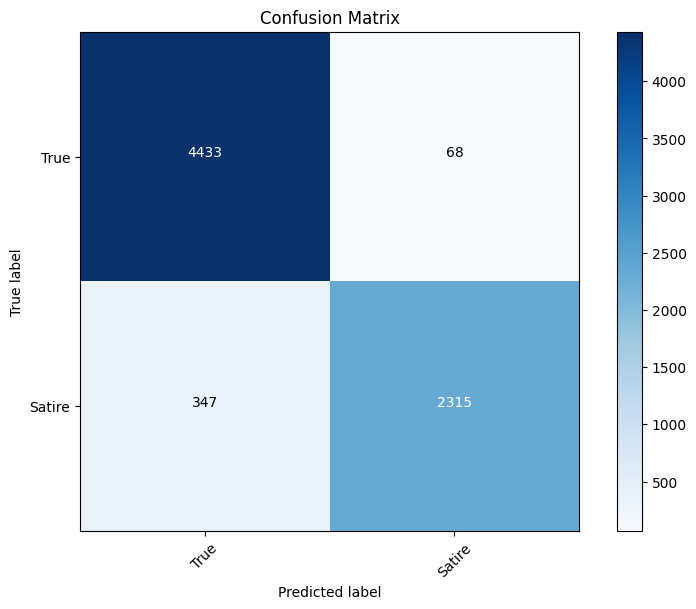

224/224 [==============================] - 13s 56ms/step
Most important features (token indices):
Token Index: 0, Importance: 0.0
Token Index: 1, Importance: 0.0
Token Index: 2, Importance: 0.0
Token Index: 3, Importance: 0.0
Token Index: 4, Importance: 0.0
Token Index: 5, Importance: 0.0
Token Index: 6, Importance: 0.0
Token Index: 7, Importance: 0.0
Token Index: 8, Importance: 0.0
Token Index: 9, Importance: 0.0


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix using only matplotlib.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot the confusion matrix
import itertools
plot_confusion_matrix(conf_matrix, classes=['True', 'Satire'])

from sklearn.preprocessing import LabelEncoder

def evaluate_feature_importance(model, tokenizer, X_val, y_val, num_features=30):
    # Encode the string labels to integers
    label_encoder = LabelEncoder()
    y_val_encoded = label_encoder.fit_transform(y_val)

    # Tokenize and pad the validation data
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_val_pad = pad_sequences(X_val_seq, maxlen=300)  # Use the same maxlen as in your model training

    # Evaluate the model on the original data
    original_preds = np.argmax(model.predict(X_val_pad), axis=-1)
    original_accuracy = accuracy_score(y_val_encoded, original_preds)
    
    feature_importances = []

    # Shuffle each feature and evaluate the impact on model performance
    for feature_idx in range(num_features):
        # Copy the dataset
        X_val_shuffled = X_val_pad.copy()

        # Shuffle a single feature across all samples
        np.random.shuffle(X_val_shuffled[:, feature_idx])

        # Evaluate the model on the shuffled data
        shuffled_preds = np.argmax(model.predict(X_val_shuffled), axis=-1)
        shuffled_accuracy = accuracy_score(y_val_encoded, shuffled_preds)

        # The importance is the difference in accuracy
        importance = original_accuracy - shuffled_accuracy
        feature_importances.append((feature_idx, importance))

    # Sort features by importance
    feature_importances.sort(key=lambda x: x[1], reverse=True)

    return feature_importances

# Run the feature importance evaluation
important_features = evaluate_feature_importance(model, tokenizer, X_val, y_val)
print("Most important features (token indices):")
for feature in important_features[:10]:  # Display top 10 important features
    print(f"Token Index: {feature[0]}, Importance: {feature[1]}")



In [12]:
import os
# Save model locally
#model.save('/opt/ml/model/my_model')

import joblib
from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")
model_name = f"model_{current_date}.pkl"
joblib.dump(model, model_name)

['model_20231202.pkl']

In [24]:
# Upload to S3
s3 = boto3.client('s3')
bucket_name = "satire-spotter-data"
model_key = 'my_model_directory'

s3.upload_file(model_name, bucket_name, f'{model_key}/{model_name}')

# Use the S3 client
#for file in os.listdir('/opt/ml/model/my_model/assets'):
#    s3.upload_file(f'/opt/ml/model/my_model/assets/{file}', bucket_name, f'{model_key}/{file}')